In [59]:
from sklearn.linear_model import RidgeCV
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *

# from sklearn.pipeline import make_pipeline
# model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

teams_dict, teams_list = get_teams(league="NBA")
box_DIR = "../data/box/"
img_DIR_T = "../data/images/teams/"

In [36]:
def get_ratings(season=2024,date="2024-12-31"):
    cols = [
        "gameId",
        "teamName",
        "teamId",
        "offensiveRating",
        "defensiveRating",
        "netRating",
        "possessions",
    ]
    df = pd.read_parquet(box_DIR + f"NBA_Box_T_Adv_{season}.parquet", columns=cols)
    cols = ["gameId", "team", "tId", "ORtg", "DRtg", "NRtg", "poss"]
    df.columns = cols
    df1 = df.groupby("gameId")
    df1_1 = df1.nth(0)
    df1_2 = df1.nth(1)
    df1_1.columns = ["gameId"] + [s + "1" for s in df1_1.columns if s != "gameId"]
    df1_2.columns = ["gameId"] + [s + "2" for s in df1_2.columns if s != "gameId"]
    df1_3 = pd.merge(df1_1, df1_2, on="gameId")
    df1_4 = df1.nth(1)
    df1_5 = df1.nth(0)
    df1_4.columns = ["gameId"] + [s + "1" for s in df1_4.columns if s != "gameId"]
    df1_5.columns = ["gameId"] + [s + "2" for s in df1_5.columns if s != "gameId"]
    df1_6 = pd.merge(df1_4, df1_5, on="gameId")
    df2 = pd.concat([df1_3, df1_6]).sort_values(by="gameId").reset_index(drop=True)
    data1 = df2.copy()
    stats = leaguegamelog.LeagueGameLog(
        player_or_team_abbreviation="T",
        season=season,
        season_type_all_star="Regular Season",
    )
    df10 = stats.get_data_frames()[0]
    df10["GAME_DATE"] = pd.to_datetime(df10["GAME_DATE"])
    df10 = df10.query(f"GAME_DATE < '{date}'").reset_index(drop=True)
    df10["HOME"] = ~df10["MATCHUP"].str.contains("@")
    df10["tId1"] = df10["TEAM_ID"]
    df10["gameId"] = df10["GAME_ID"]
    df10["date"] = df10["GAME_DATE"]
    df11 = (
        df10[["gameId", "tId1", "HOME","date"]].sort_values(by="date").reset_index(drop=True)
    )
    df11[["gameId", "tId1"]] = df11[["gameId", "tId1"]].astype(int)
    data = pd.merge(data1, df11,how="right")
    return data

In [47]:
def process_results(data):
    data["pts1"] = data["ORtg1"] * data["poss1"]
    data["pts2"] = data["DRtg1"] * data["poss1"]
    off_prior = data.groupby(["tId1"])[["poss1", "pts1"]].agg("sum").reset_index()
    def_prior = data.groupby(["tId1"])[["poss1", "pts2"]].agg("sum").reset_index()
    off_prior["OFF"] = off_prior["pts1"] / off_prior["poss1"]
    off_prior = off_prior[["tId1", "OFF"]]
    def_prior["DEF"] = def_prior["pts2"] / def_prior["poss1"]
    def_prior = def_prior[["tId1", "DEF"]]
    results_net = pd.merge(off_prior, def_prior, on=["tId1"])
    results_net["NET"] = results_net["OFF"] - results_net["DEF"]
    results_net.rename(columns={"tId1": "tId"}, inplace=True)
    results_net = results_net.astype(float).round(2)
    results_net["tId"] = results_net["tId"].astype(int)
    ortg_mean = data["pts1"].sum() / data["poss1"].sum()
    drtg_mean = data["pts2"].sum() / data["poss1"].sum()
    results_net["Team"] = results_net["tId"].map(teams_dict)
    results_net.iloc[:, 1:] = results_net.iloc[:, 1:].round(1)
    results = results_net[
        ["Team", "OFF", "DEF",  "NET",]
    ]
    return results

In [37]:
d23 = get_ratings(season=2023,date="2023-12-25")
d24 = get_ratings(season=2024,date="2024-12-25")

In [48]:
r23 = process_results(d23)
r24 = process_results(d24)

In [55]:
dm = pd.merge(r23,r24,on="Team",suffixes=["_23","_24"])
dm["OFF_23_R"] = dm["OFF_23"].rank(ascending=False  ,method="first").astype(int)
dm["DEF_23_R"] = dm["DEF_23"].rank(ascending=True   ,method="first").astype(int)
dm["NET_23_R"] = dm["NET_23"].rank(ascending=False  ,method="first").astype(int)
dm["OFF_24_R"] = dm["OFF_24"].rank(ascending=False,method="first").astype(int)
dm["DEF_24_R"] = dm["DEF_24"].rank(ascending=True ,method="first").astype(int)
dm["NET_24_R"] = dm["NET_24"].rank(ascending=False,method="first").astype(int)

In [62]:
df_teams = pd.read_csv("../data/NBA_teams_colors_logos.csv")
df_teams = df_teams.rename(columns={"nameTeam": "Team"})
results_plot = pd.merge(dm, df_teams)
results_plot["image"] = img_DIR_T + results_plot["Team"] + ".png"

In [57]:
black1 = '#252525'
black2 = '#222222'

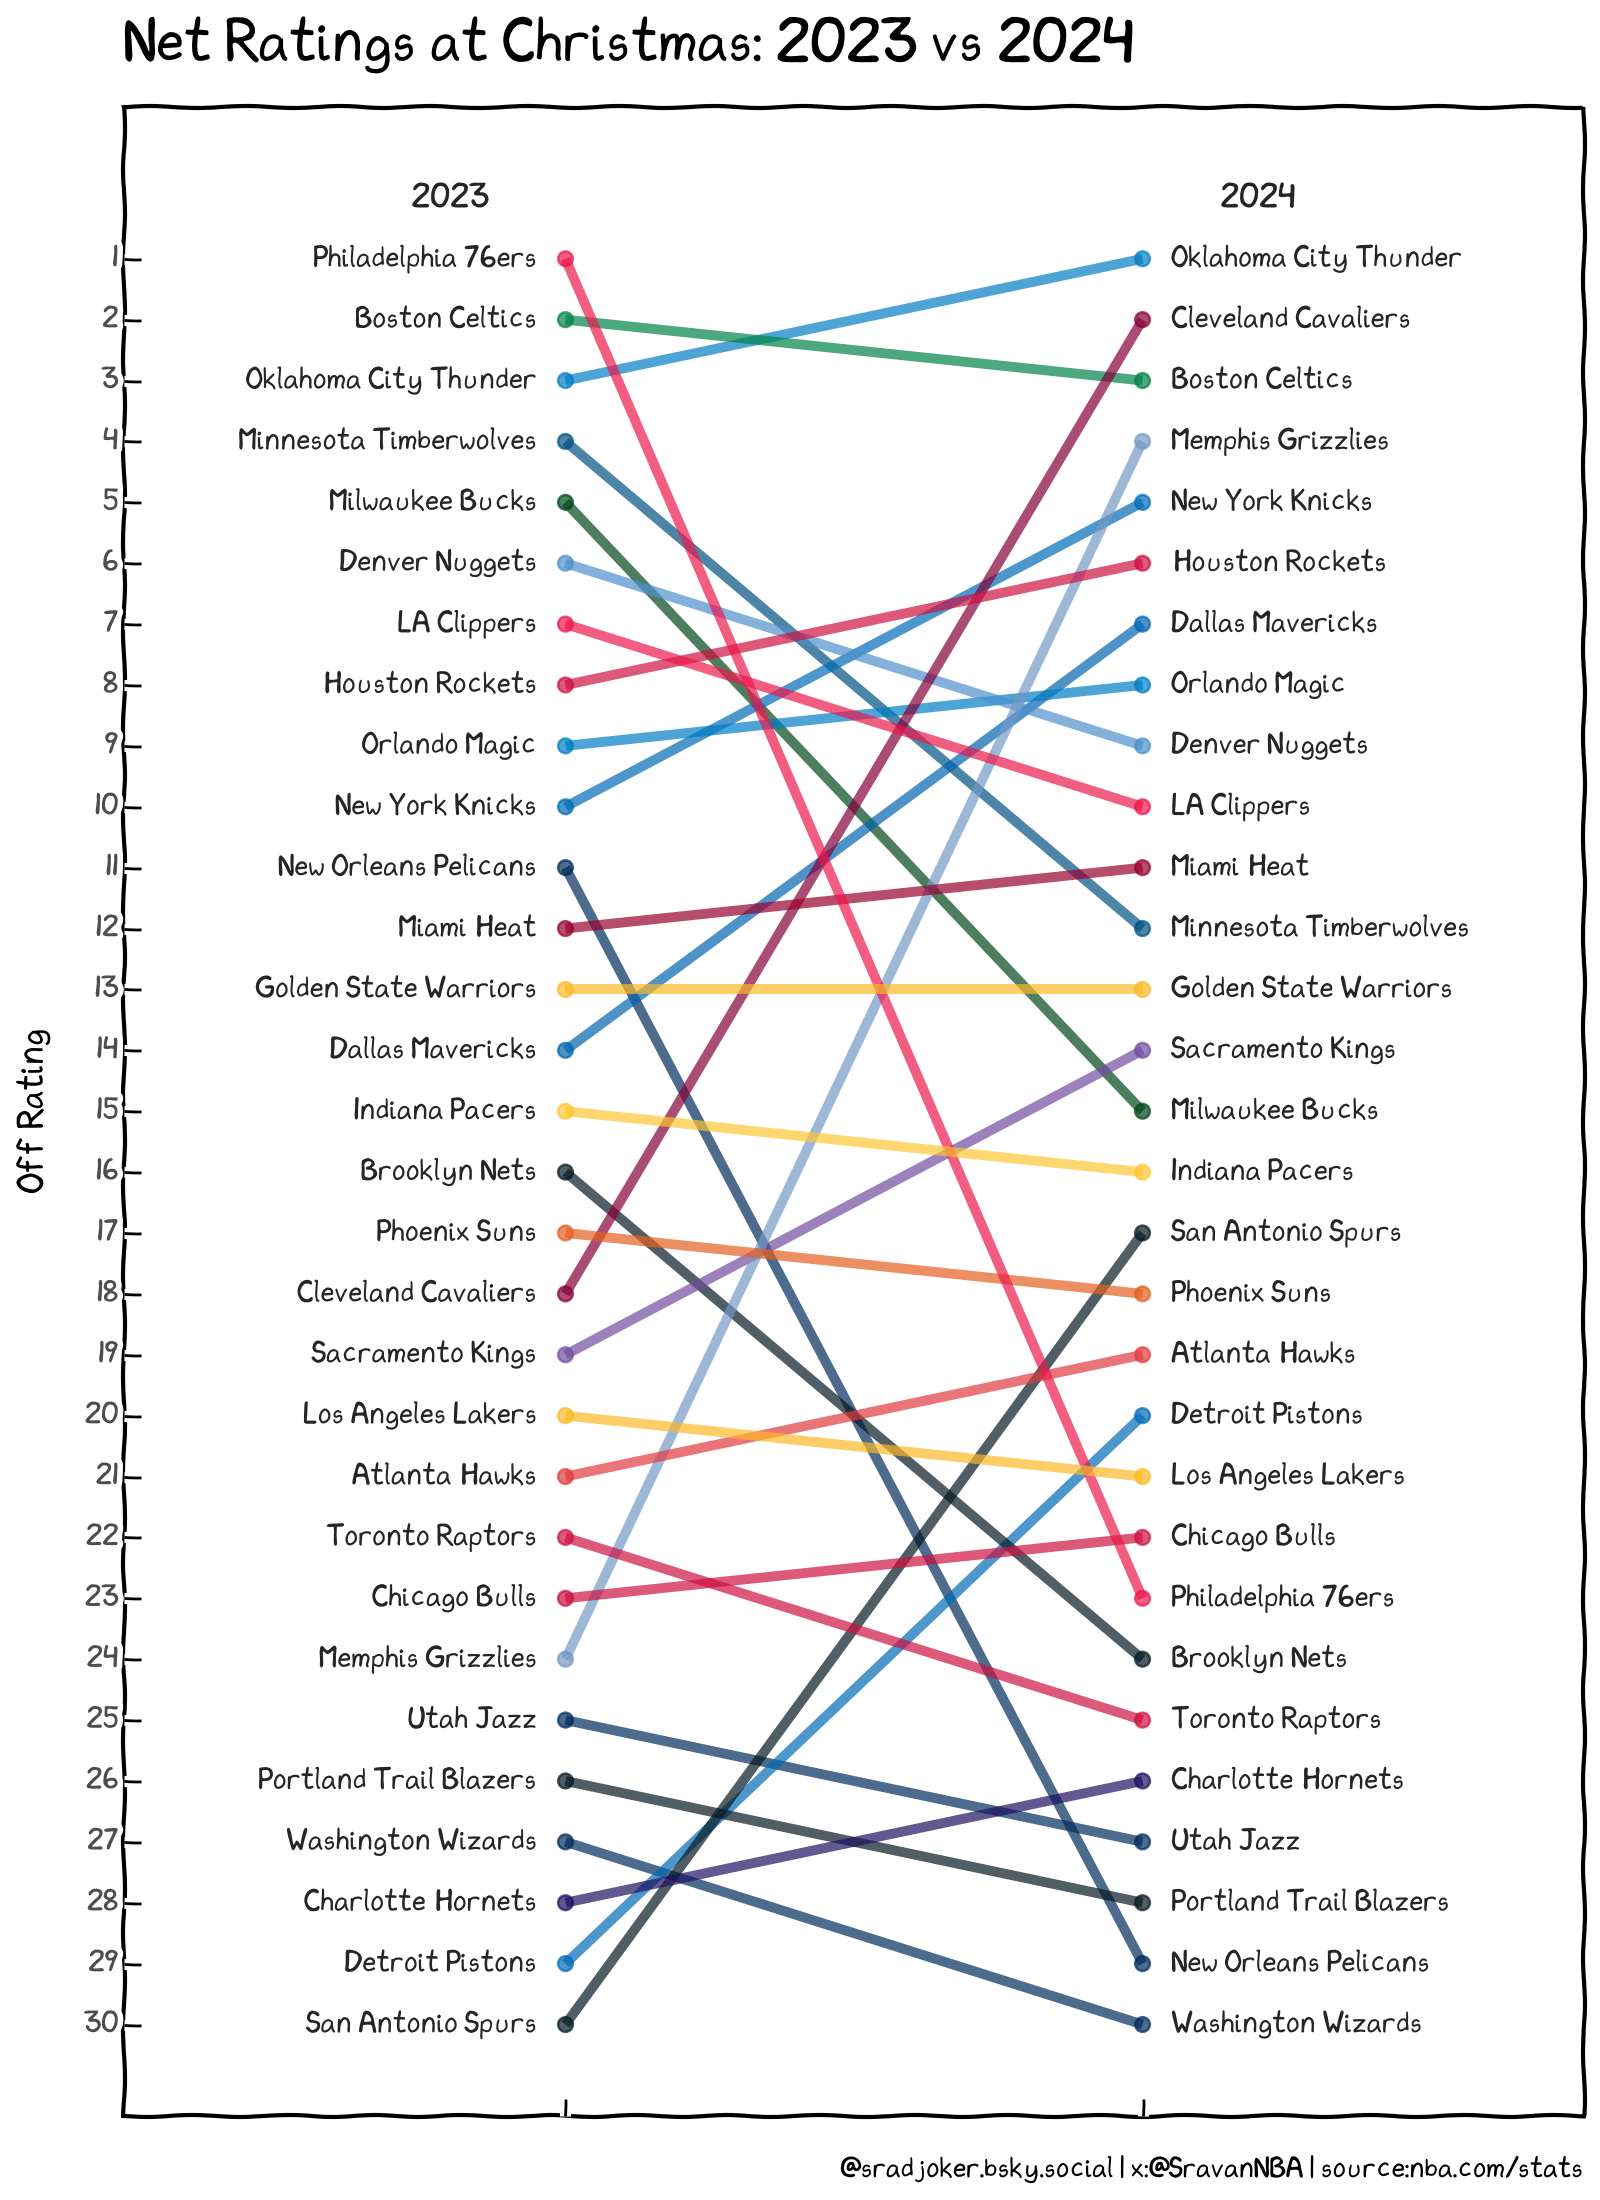

<Figure Size: (800 x 1100)>

In [58]:
p = (ggplot(results_plot)
 + geom_text(aes(1, 'NET_23_R', label='Team' ), nudge_x=-0.05, ha='right', size=10, color=black1)
 + geom_text(aes(2, 'NET_24_R', label='Team'), nudge_x=0.05, ha='left', size=10, color=black1)
 + geom_point(aes(1, 'NET_23_R', color='colorsTeam'), size=2.5, alpha=.7)
 + geom_point(aes(2, 'NET_24_R', color='colorsTeam'), size=2.5, alpha=.7)
 + geom_segment(aes(x=1, y='NET_23_R', xend=2, yend='NET_24_R', color='colorsTeam'), alpha=.7, size=2)
 + annotate('text', x=0.8, y=0, label='2023', size=11, color=black1)
 + annotate('text', x=2.2, y=0, label='2024', size=11, color=black1)
 + lims(x=(0.35, 2.65))
 + scale_y_reverse(breaks=np.arange(1,31,1))
 + scale_color_identity(aesthetics=["color"])
 + theme_idv
 + theme(figure_size=(8, 11))
 + theme(
     axis_title_x = element_blank(),
     axis_text_x = element_blank(),
     plot_title=element_text(face="bold", size=20),
 )
 + labs(
        title=f"Net Ratings at Christmas: 2023 vs 2024",
        # subtitle = "Last 10 games only",
        caption="@sradjoker.bsky.social | x:@SravanNBA | source:nba.com/stats",
        y=f"Off Rating",
 )
)
# p.save("../figs/teams/ratings_compare_season.png", dpi=300, verbose = False)
p

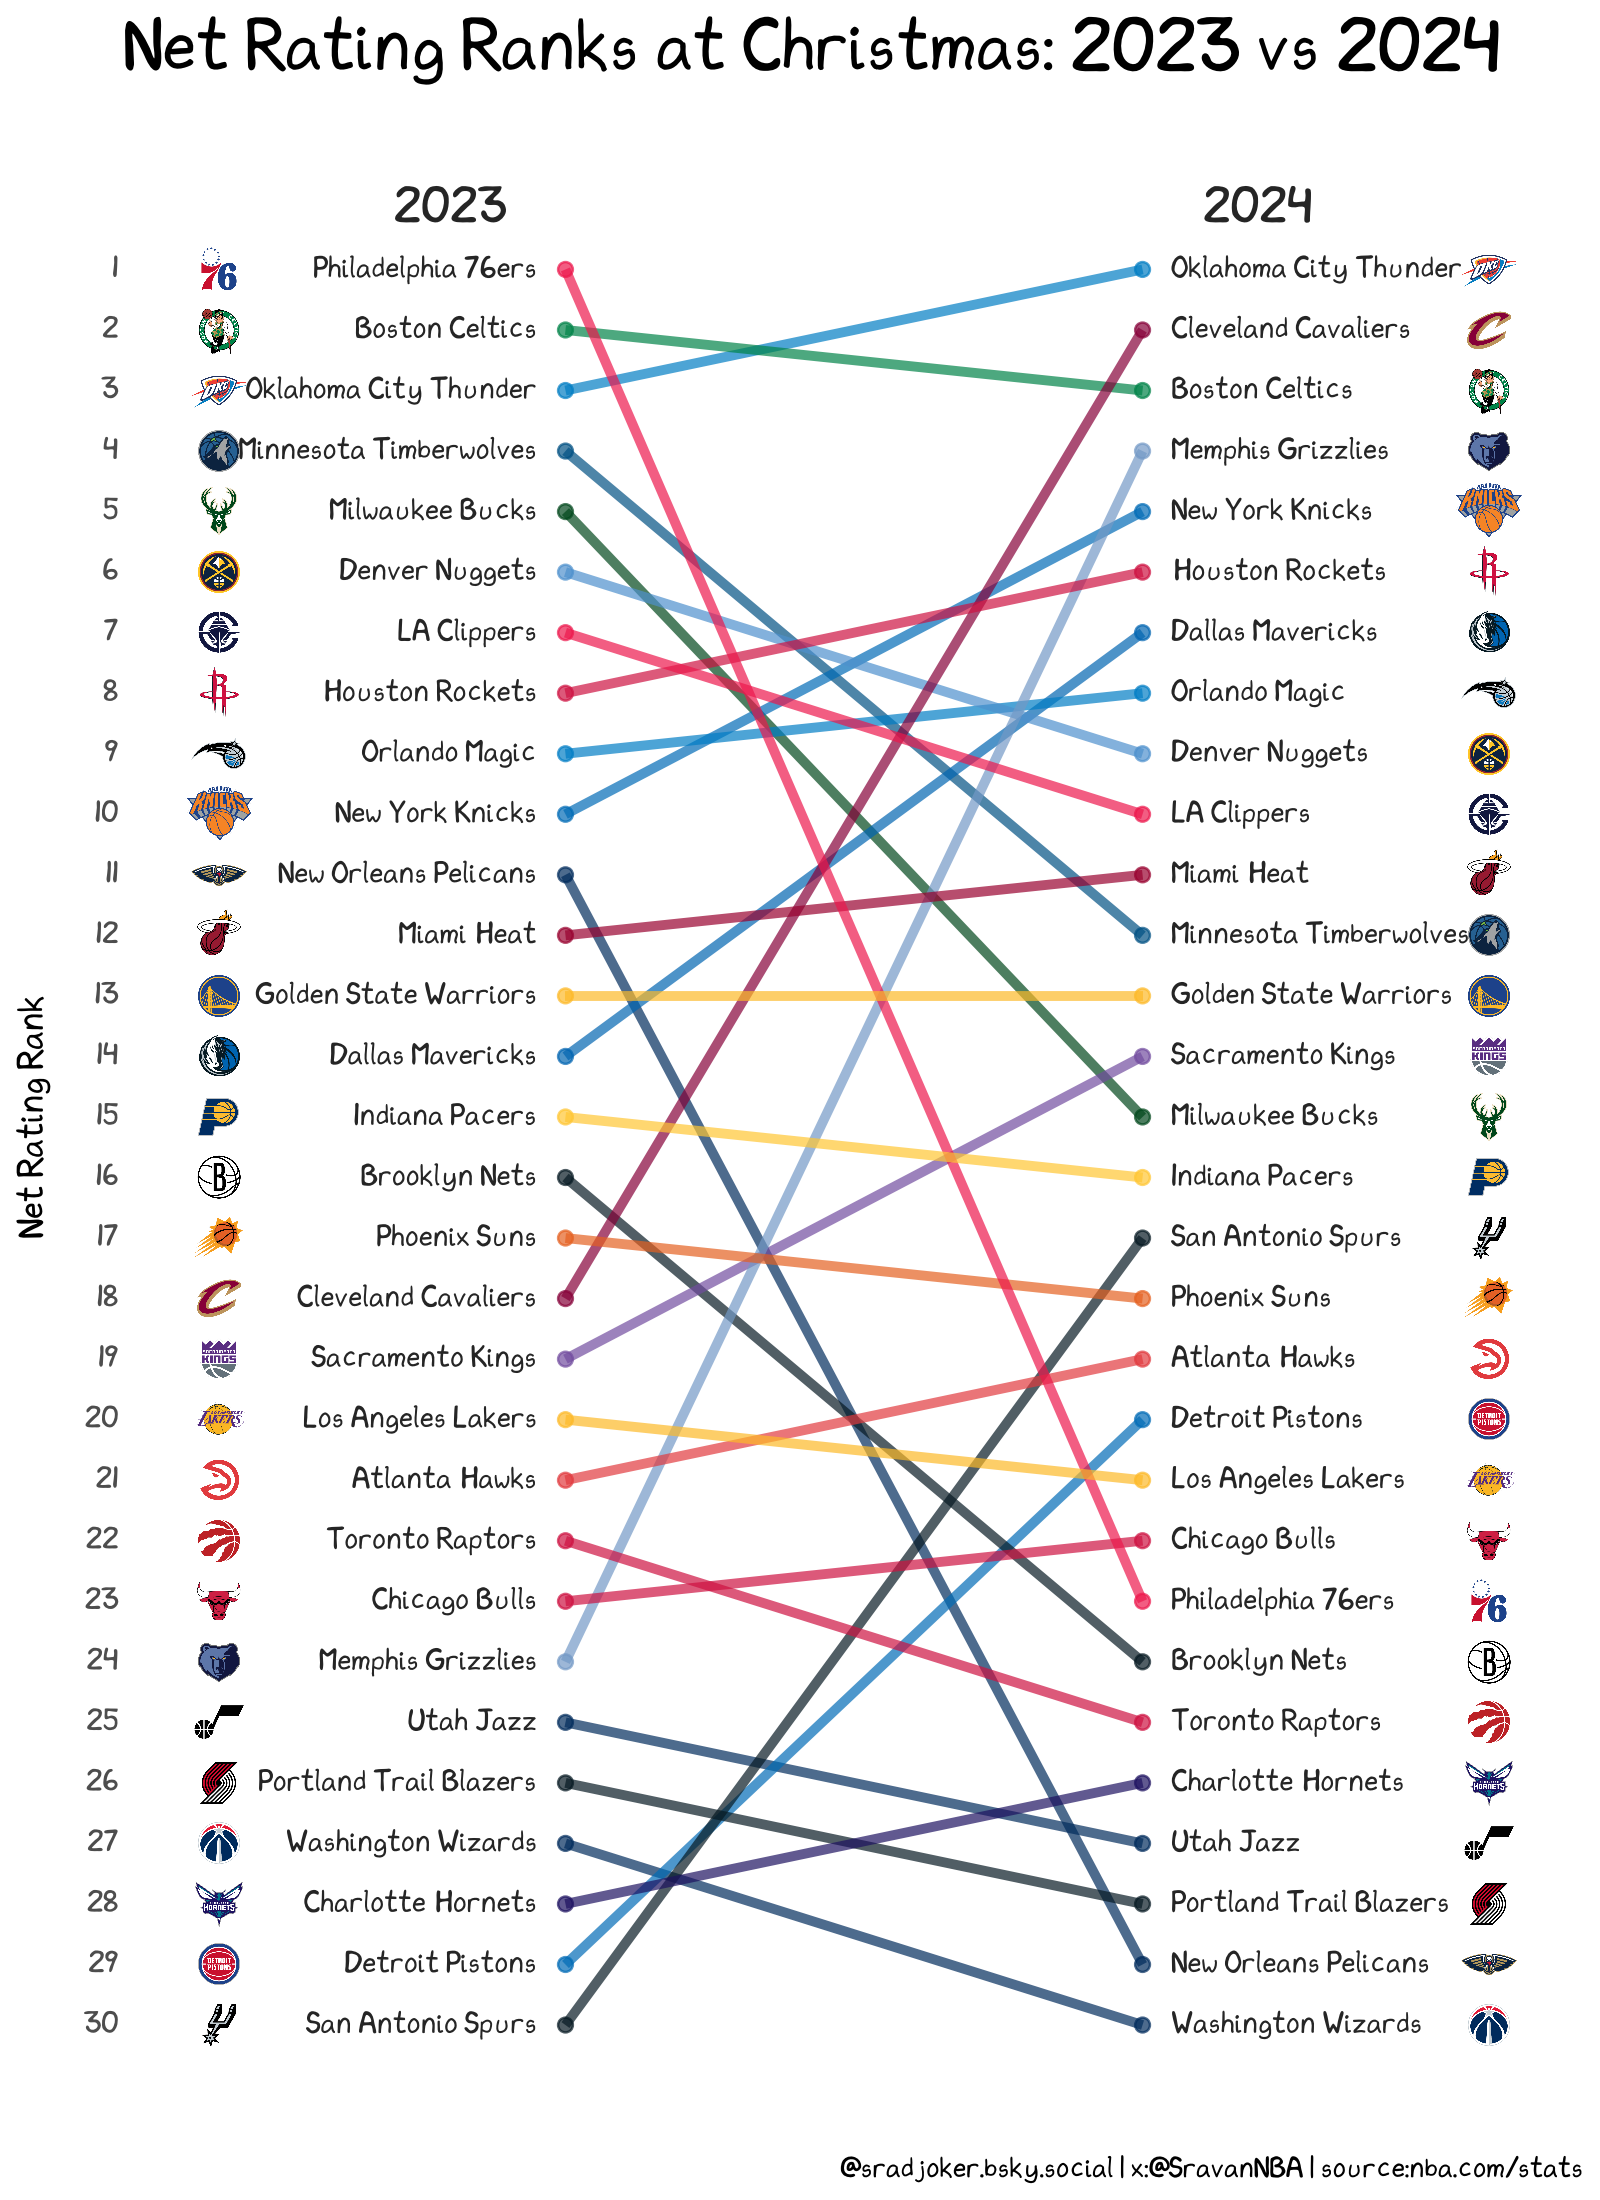

<Figure Size: (800 x 1100)>

In [65]:
p = (ggplot(results_plot)
 + geom_text(aes(1, 'NET_23_R', label='Team' ), nudge_x=-0.05, ha='right', size=10, color=black1)
 + geom_text(aes(2, 'NET_24_R', label='Team'), nudge_x=0.05, ha='left', size=10, color=black1)
 + geom_point(aes(1, 'NET_23_R', color='colorsTeam'), size=2.5, alpha=.7)
 + geom_point(aes(2, 'NET_24_R', color='colorsTeam'), size=2.5, alpha=.7)
 + geom_segment(aes(x=1, y='NET_23_R', xend=2, yend='NET_24_R', color='colorsTeam'), alpha=.7, size=2)
 + geom_image(aes(x=0.4, y='NET_23_R',image="image"),size=0.05)
 + geom_image(aes(x=2.6, y='NET_24_R',image="image"),size=0.05)
 + annotate('text', x=0.8, y=0, label='2023', size=16, color=black1)
 + annotate('text', x=2.2, y=0, label='2024', size=16, color=black1)
 + lims(x=(0.35, 2.65))
 + scale_y_reverse(breaks=np.arange(1,31,1))
 + scale_color_identity(aesthetics=["color"])
 + theme_idv
 + theme(figure_size=(8, 11))
 + theme(
     axis_title_x = element_blank(),
     axis_text_x = element_blank(),
     plot_title=element_text(face="bold", size=24),
     plot_subtitle=element_text(size=18),
     panel_border=element_blank(),
     axis_ticks=element_blank(),
 )
 + labs(
        title=f"Net Rating Ranks at Christmas: 2023 vs 2024",
        # subtitle = "Last 10 games only",
        caption="@sradjoker.bsky.social | x:@SravanNBA | source:nba.com/stats",
        y=f"Net Rating Rank",
 )
)
# p.save("../figs/team_leaders/m_Net_mvmt.png", dpi=300, verbose = False)
p